In [57]:

import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, f1_score,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.pipeline import Pipeline
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import shap
import gradio as gr
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import torch

In [58]:
nlp = spacy.load("en_core_web_sm")

In [59]:
print(torch.cuda.is_available())  # should return True
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce GTX 1060 with Max-Q Design


In [4]:
def clean_text_and_info(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    entities = [f"{ent.text}: {ent.label_}" for ent in doc.ents]
    pos_tags = [(token.text, token.pos_) for token in doc]
    print("\nCleaned Tokens:")
    print(tokens)
    print("\nNamed Entities")
    if entities:
        for item in entities:
            print(item)
    else:
        print("No named entity found")
    print("\nPart of speech Tags")
    for word, pos in pos_tags:
        print(f"{word}-- {pos}")
    return tokens, entities, pos_tags


In [60]:
train_dataset = pd.read_csv("train.tsv",sep='\t', header=None)
train_dataset.to_csv("cleaned_train.csv", index=False)

In [61]:
val_dataset = pd.read_csv("valid.tsv",sep='\t', header=None)
val_dataset.to_csv("cleaned_validation.csv", index=False)

In [62]:
test_dataset = pd.read_csv("test.tsv",sep='\t', header=None)
test_dataset.to_csv("cleaned_test.csv", index=False)

In [8]:
train_dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10236,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10237,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate
10238,2253.json,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...


In [64]:
train_dataset.columns = [
    "id", "label", "statement", "subject", "speaker", "speaker_job", 
    "state_info", "party_affiliation", "barely_true_counts", "false_counts", 
    "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"
]
val_dataset.columns = [  "id", "label", "statement", "subject", "speaker", "speaker_job", 
    "state_info", "party_affiliation", "barely_true_counts", "false_counts", 
    "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"

]
test_dataset.columns = [  "id", "label", "statement", "subject", "speaker", "speaker_job", 
    "state_info", "party_affiliation", "barely_true_counts", "false_counts", 
    "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"

]

In [65]:
nlpTrain_df = train_dataset[["label", "statement"]]
nlpVal_df = val_dataset[["label", "statement"]]
nlptest_df = test_dataset[["label", "statement"]]

In [66]:
nlpTrain_df["label"].unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [67]:
nlp_multiclass_labels = {'false':0,
                         'pants-fire':0,
                         'barely-true':0,
                          'half-true':1,
                          'mostly-true':1,
                          'true': 1
                         }

In [68]:
nlpTrain_df_copy = nlpTrain_df.copy() 
nlpVal_df_copy = nlpVal_df.copy()
nlptest_copy = nlptest_df.copy()

In [69]:
nlpTrain_df_copy["label"] = nlpTrain_df["label"].map(nlp_multiclass_labels)
nlpVal_df_copy["label"] = nlpVal_df_copy["label"].map(nlp_multiclass_labels)
nlptest_copy["label"] = nlptest_copy["label"].map(nlp_multiclass_labels)

In [70]:
nlpTrain_df_copy

,label,statement
0,0,Says the Annies List political group supports ...
1,1,When did the decline of coal start? It started...
2,1,"Hillary Clinton agrees with John McCain ""by vo..."
3,0,Health care reform legislation is likely to ma...
4,1,The economic turnaround started at the end of ...
...,...,...
10235,1,There are a larger number of shark attacks in ...
10236,1,Democrats have now become the party of the [At...
10237,1,Says an alternative to Social Security that op...
10238,0,On lifting the U.S. Cuban embargo and allowing...


In [16]:
tfIDF_vectorizer = TfidfVectorizer(lowercase=True,stop_words='english',max_df=0.75, min_df=1,  ngram_range=(1,2), max_features=None)


In [17]:
X_tfDIF_train = tfIDF_vectorizer.fit_transform(nlpTrain_df_copy["statement"])
X_tfDIF_val = tfIDF_vectorizer.transform(nlpVal_df_copy["statement"])
X_tfDIF_test = tfIDF_vectorizer.transform(nlptest_copy["statement"])

In [18]:
Y_tfDIF_train = nlpTrain_df_copy["label"].values
Y_tfDIF_val = nlpVal_df_copy["label"].values
Y_tfDif_test = nlptest_copy["label"].values

In [20]:
logistic_regresion_model = LogisticRegression(max_iter=1000)

In [21]:
logistic_regresion_model.fit(X_tfDIF_train,Y_tfDIF_train)

LogisticRegression(max_iter=1000)

In [22]:
y_val_prediction = logistic_regresion_model.predict(X_tfDIF_val)

In [23]:
y_test_prediction = logistic_regresion_model.predict(X_tfDIF_test)

In [26]:
print("Validation\n", classification_report(Y_tfDIF_val,y_val_prediction))

Validation
               precision    recall  f1-score   support

           0       0.65      0.44      0.52       616
           1       0.60      0.78      0.68       668

    accuracy                           0.62      1284
   macro avg       0.62      0.61      0.60      1284
weighted avg       0.62      0.62      0.60      1284



In [27]:
print("test\n", classification_report(Y_tfDif_test, y_test_prediction))

test
               precision    recall  f1-score   support

           0       0.59      0.39      0.47       553
           1       0.62      0.79      0.70       714

    accuracy                           0.61      1267
   macro avg       0.61      0.59      0.58      1267
weighted avg       0.61      0.61      0.60      1267



In [28]:
Logistic_weight = logistic_regresion_model.coef_[0]
feature_names = tfIDF_vectorizer.get_feature_names_out()

In [29]:
top_fake_indices_Logis = np.argsort(Logistic_weight)[-20:]
top_fake_words_logis = [(feature_names[i], Logistic_weight[i]) for i in top_fake_indices_Logis[::-1]]

In [30]:
for word, score in top_fake_words_logis:
    print(f"{word}: {score:.4f}")

percent: 2.9294
countries: 1.9250
georgia: 1.8589
day: 1.8558
million: 1.8066
average: 1.7966
times: 1.7482
debt: 1.6412
months: 1.4744
highest: 1.4207
half: 1.4001
country: 1.3400
american: 1.3323
000: 1.2879
cut: 1.2436
60: 1.1934
terms: 1.1410
americans: 1.1295
lower: 1.1201
cities: 1.1065


In [31]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(class_weight="balanced", max_iter=1000))

])

In [32]:
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.75, 0.9, 0.95],
    'tfidf__min_df': [1, 2, 5],
    'tfidf__max_features': [5000, 10000, None],
    'clf__C': [0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [28]:
grid_search.fit(nlpTrain_df_copy["statement"],nlpTrain_df_copy["label"])

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10, 100],
                         'tfidf__max_df': [0.75, 0.9, 0.95],
                         'tfidf__max_features': [5000, 10000, None],
                         'tfidf__min_df': [1, 2, 5],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1', verbose=1)

In [29]:
best_model = grid_search.best_estimator_

In [30]:
val_predict = best_model.predict(nlpVal_df_copy["statement"])
print(classification_report(nlpVal_df_copy["label"],val_predict))

              precision    recall  f1-score   support

           0       0.58      0.55      0.56       616
           1       0.60      0.64      0.62       668

    accuracy                           0.60      1284
   macro avg       0.59      0.59      0.59      1284
weighted avg       0.59      0.60      0.59      1284



In [31]:
print("Best Params:", grid_search.best_params_)

Best Params: {'clf__C': 10, 'tfidf__max_df': 0.75, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


In [32]:
nlpTrain_df["label"].value_counts()

label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64

In [34]:
new_text = ["Shahriar is better looking than Brad Pit"]
new_prediction = best_model.predict(new_text)
print("Prediction", new_prediction[0])
def printer(predicton):
    if predicton == 1:
        return "TRUE STATMENT"
    else:
        return "False"
printer(new_prediction)

NameError: name 'best_model' is not defined

In [35]:
neg, pos = (Y_tfDIF_train ==0).sum(), (Y_tfDIF_train == 1).sum()
scale = neg / pos

In [36]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale, randon_state=42)
xgb_model.fit(X_tfDIF_train,Y_tfDIF_train)

c:\Users\17207\miniconda3\envs\practinlp\lib\site-packages\xgboost\training.py:183: UserWarning: [07:23:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "randon_state", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [38]:
y_xg_predict = xgb_model.predict(X_tfDIF_val)
y_xgb_predict_test = xgb_model.predict(X_tfDIF_test)

In [37]:
print("Accuracy:", accuracy_score(Y_tfDIF_val, y_xg_predict))
print("\nClassification Report:\n", classification_report(Y_tfDIF_val, y_xg_predict))
print("\nConfusion Matrix:\n", confusion_matrix(Y_tfDIF_val, y_xg_predict))

Accuracy: 0.5926791277258567

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.65      0.60       616
           1       0.62      0.54      0.58       668

    accuracy                           0.59      1284
   macro avg       0.60      0.59      0.59      1284
weighted avg       0.60      0.59      0.59      1284


Confusion Matrix:
 [[398 218]
 [305 363]]


In [39]:
print("Test Accuracy:", accuracy_score(Y_tfDif_test, y_xgb_predict_test))
print("\nClassification Report:\n", classification_report(Y_tfDif_test, y_xgb_predict_test))
print("\nConfusion Matrix:\n", confusion_matrix(Y_tfDif_test, y_xgb_predict_test))

Test Accuracy: 0.5919494869771112

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.61      0.57       553
           1       0.66      0.57      0.61       714

    accuracy                           0.59      1267
   macro avg       0.59      0.59      0.59      1267
weighted avg       0.60      0.59      0.59      1267


Confusion Matrix:
 [[340 213]
 [304 410]]


In [40]:
xg_param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],  # skip 0.01 for now
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [1, 2]
}

In [41]:
xgb_base = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [42]:
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xg_param_grid,
    n_iter=20,
    scoring='f1_macro',   # instead of just 'f1'
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [41]:
random_search.fit(X_tfDIF_train, Y_tfDIF_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\17207\miniconda3\envs\practinlp\lib\site-packages\xgboost\training.py:183: UserWarning: [21:02:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [0, 1],
                                        'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [200, 300, 400],
                                        'reg_alpha': [0, 0.5],
                                        'reg_lambda': [1, 2],
                                        'subsample': [0.8, 0.9]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [42]:
print("Best Parameters:\n", random_search.best_params_)
best_xgb = random_search.best_estimator_
y_xg_predict = best_xgb.predict(X_tfDIF_val)
print("\nClassification Report:\n", classification_report(Y_tfDIF_val, y_xg_predict))

Best Parameters:
 {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.44      0.51       616
           1       0.59      0.73      0.65       668

    accuracy                           0.59      1284
   macro avg       0.59      0.59      0.58      1284
weighted avg       0.59      0.59      0.58      1284



In [43]:
xgb_importnace = best_xgb.feature_importances_

In [44]:
feature_names = tfIDF_vectorizer.get_feature_names_out()

In [45]:
indicies = np.argsort(xgb_importnace)[-30:][::-1]
top_xgb_features = [feature_names[i] for i in indicies]
top_xgb_importances = xgb_importnace[indicies]

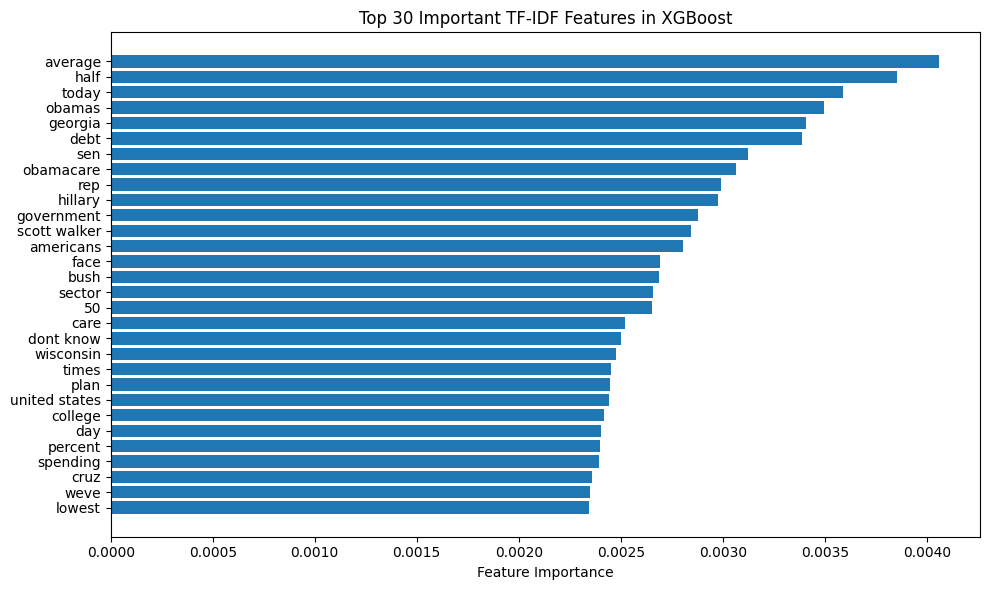

In [46]:
plt.figure(figsize=(10, 6))
plt.barh(top_xgb_features[::-1], top_xgb_importances[::-1])
plt.title("Top 30 Important TF-IDF Features in XGBoost")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

In [18]:
X_dense_train = X_tfDIF_train.toarray()
X_dense_val = X_tfDIF_val.toarray()

In [19]:
explainer = shap.TreeExplainer(best_xgb.get_booster())

NameError: name 'best_xgb' is not defined

In [ ]:
shap_values = explainer.shap_values(X_dense_val)

In [50]:
shap_matrix = np.abs(shap_values).sum(axis=0)

In [51]:
shap_df = pd.DataFrame({
    'feature': feature_names,
    'shap_sum': shap_matrix
}).sort_values(by='shap_sum', ascending=False)

In [52]:
print(shap_df.head(30))

           feature     shap_sum
63028  says donald  1132.507080
40611        legal  1070.788208
44146        media  1048.390259
20327     deciding   919.448975
33778      history   913.125061
75987           ve   897.536072
7810          auto   889.794617
41884    lobbyists   875.207031
22526         does   870.284424
73767      traffic   854.982666
62758         says   850.528625
67508    sponsored   841.377869
68967         stop   827.395752
41450       likely   827.154419
14384       cities   805.175415
29329      funding   798.416443
23947     economic   785.548889
43001       making   777.002563
57842         real   748.844055
18445       create   747.522888
20127         debt   741.386353
20271      decades   741.240173
725             14   712.939514
36755     internet   711.338806
79785        worst   698.671021
14906      clinton   692.453491
76426    virginias   685.326965
28664      foreign   675.112549
63728       scheme   667.673401
11872       called   664.724426


In [53]:
joblib.dump(best_model, 'xgboost_model.pkl')
joblib.dump(tfIDF_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [54]:
def predict_news(text):
    model = joblib.load("xgboost_model.pkl")
    prob = model.predict_proba([text])[0][1]
    label = "Fake" if prob >= 0.5 else "Real"
    return f"{label}({prob:0.2%} confidence)"

In [55]:
#iface = gr.Interface(
##    inputs="text",
 #   outputs = "text",
 #   title = "Fake news Detector",
 #   description = "Enter a new headline or short artilce, This app uses a machine learning model to predict whether it's real or fake."
#)
#iface.launch()

In [56]:
model = joblib.load("xgboost_model.pkl")

In [57]:
nlpTrain_df

,label,statement
0,false,Says the Annies List political group supports ...
1,half-true,When did the decline of coal start? It started...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
3,false,Health care reform legislation is likely to ma...
4,half-true,The economic turnaround started at the end of ...
...,...,...
10235,mostly-true,There are a larger number of shark attacks in ...
10236,mostly-true,Democrats have now become the party of the [At...
10237,half-true,Says an alternative to Social Security that op...
10238,false,On lifting the U.S. Cuban embargo and allowing...


In [71]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

c:\Users\17207\miniconda3\envs\practinlp\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [72]:
hf_dataset = Dataset.from_pandas(nlpTrain_df_copy)
hf_dataset_val = Dataset.from_pandas(nlpVal_df_copy)
hf_dataset_test = Dataset.from_pandas(nlptest_copy)

In [73]:
def tokenized_function(x):
    return bert_tokenizer(x["statement"], padding='max_length',truncation=True)

In [74]:
tokenized_train_bert = hf_dataset.map(tokenized_function, batched=True)

Map:   0%|          | 0/10240 [00:00<?, ? examples/s]

In [75]:
tokenized_val_bert = hf_dataset_val.map(tokenized_function, batched=True)

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

In [76]:
tokenized_test_bert = hf_dataset_test.map(tokenized_function, batched=True)

Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

In [77]:
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
train_args = TrainingArguments(
    output_dir="D:/bert_outputs",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    no_cuda=True
)

c:\Users\17207\miniconda3\envs\practinlp\lib\site-packages\transformers\training_args.py:1453: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [79]:
labels_training_bert = tokenized_train_bert["label"]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels_training_bert), y=labels_training_bert)
weights = torch.tensor(class_weights, dtype=torch.float)

In [80]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=weights.to(logits.device))
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [29]:
import transformers
print(transformers.__version__)

4.40.1


In [30]:
print(transformers.__version__)
print(transformers.__file__)

4.40.1
c:\Users\17207\miniconda3\envs\practinlp\lib\site-packages\transformers\__init__.py


In [81]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels,preds)
    f1 = f1_score(labels,preds)
    return {'accuracy': acc, "f1": f1}

In [82]:
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

CUDA available: True
Device: NVIDIA GeForce GTX 1060 with Max-Q Design


In [83]:
trainer = WeightedTrainer(
    model=bert_model,
    args=train_args,
    train_dataset=tokenized_train_bert,
    eval_dataset= tokenized_val_bert,
    compute_metrics=compute_metrics,
    tokenizer=bert_tokenizer,
)

In [29]:
trainer.train()

  0%|          | 0/7680 [00:00<?, ?it/s]

{'loss': 0.692, 'grad_norm': 5.694543838500977, 'learning_rate': 1.869791666666667e-05, 'epoch': 0.2}
{'loss': 0.6986, 'grad_norm': 7.5368804931640625, 'learning_rate': 1.7395833333333334e-05, 'epoch': 0.39}
{'loss': 0.6763, 'grad_norm': 9.859539031982422, 'learning_rate': 1.609375e-05, 'epoch': 0.59}
{'loss': 0.6798, 'grad_norm': 4.782614707946777, 'learning_rate': 1.479166666666667e-05, 'epoch': 0.78}
{'loss': 0.666, 'grad_norm': 5.355681896209717, 'learning_rate': 1.3489583333333334e-05, 'epoch': 0.98}


  0%|          | 0/321 [00:00<?, ?it/s]

{'eval_loss': 0.6534720063209534, 'eval_accuracy': 0.6456386292834891, 'eval_f1': 0.6676406135865596, 'eval_runtime': 755.5301, 'eval_samples_per_second': 1.699, 'eval_steps_per_second': 0.425, 'epoch': 1.0}
{'loss': 0.6444, 'grad_norm': 7.779201984405518, 'learning_rate': 1.2187500000000001e-05, 'epoch': 1.17}
{'loss': 0.6145, 'grad_norm': 10.573111534118652, 'learning_rate': 1.0885416666666668e-05, 'epoch': 1.37}
{'loss': 0.6368, 'grad_norm': 11.98503303527832, 'learning_rate': 9.583333333333335e-06, 'epoch': 1.56}
{'loss': 0.6143, 'grad_norm': 5.088316917419434, 'learning_rate': 8.281250000000001e-06, 'epoch': 1.76}
{'loss': 0.6152, 'grad_norm': 8.648358345031738, 'learning_rate': 6.979166666666667e-06, 'epoch': 1.95}


  0%|          | 0/321 [00:00<?, ?it/s]

{'eval_loss': 0.6786410808563232, 'eval_accuracy': 0.6378504672897196, 'eval_f1': 0.7032546266751755, 'eval_runtime': 746.0301, 'eval_samples_per_second': 1.721, 'eval_steps_per_second': 0.43, 'epoch': 2.0}
{'loss': 0.5253, 'grad_norm': 13.73570442199707, 'learning_rate': 5.677083333333334e-06, 'epoch': 2.15}
{'loss': 0.5281, 'grad_norm': 31.850095748901367, 'learning_rate': 4.3750000000000005e-06, 'epoch': 2.34}
{'loss': 0.5618, 'grad_norm': 6.119119644165039, 'learning_rate': 3.072916666666667e-06, 'epoch': 2.54}
{'loss': 0.5639, 'grad_norm': 2.0117883682250977, 'learning_rate': 1.7708333333333337e-06, 'epoch': 2.73}
{'loss': 0.5227, 'grad_norm': 25.007490158081055, 'learning_rate': 4.6875000000000006e-07, 'epoch': 2.93}


  0%|          | 0/321 [00:00<?, ?it/s]

{'eval_loss': 0.8924952149391174, 'eval_accuracy': 0.633177570093458, 'eval_f1': 0.6874585268745853, 'eval_runtime': 725.2046, 'eval_samples_per_second': 1.771, 'eval_steps_per_second': 0.443, 'epoch': 3.0}
{'train_runtime': 89403.3875, 'train_samples_per_second': 0.344, 'train_steps_per_second': 0.086, 'train_loss': 0.6132333040237427, 'epoch': 3.0}


TrainOutput(global_step=7680, training_loss=0.6132333040237427, metrics={'train_runtime': 89403.3875, 'train_samples_per_second': 0.344, 'train_steps_per_second': 0.086, 'total_flos': 8082771620659200.0, 'train_loss': 0.6132333040237427, 'epoch': 3.0})

Counter({1: 5752, 0: 4488})

In [30]:
trainer.save_model("D:/bert_outputs_complete/final_model_complete")        # Saves model + tokenizer config
bert_tokenizer.save_pretrained("D:/bert_outputs_complete/final_model_complete") 

('D:/bert_outputs_complete/final_model_complete\\tokenizer_config.json',
 'D:/bert_outputs_complete/final_model_complete\\special_tokens_map.json',
 'D:/bert_outputs_complete/final_model_complete\\vocab.txt',
 'D:/bert_outputs_complete/final_model_complete\\added_tokens.json')

In [84]:
model_path = "D:/bert_outputs_complete/final_model_complete"
tokenized_loader = BertTokenizer.from_pretrained(model_path)
loaded_model = BertForSequenceClassification.from_pretrained(model_path)

In [85]:
new_trainer = WeightedTrainer(
    model=loaded_model,
    tokenizer=tokenized_loader,
)

In [86]:
test_result = new_trainer.evaluate(tokenized_test_bert)
print("Test Set Evaluation:\n", test_result)

# 2. Generate classification report
predictions = new_trainer.predict(tokenized_test_bert)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

  0%|          | 0/159 [00:00<?, ?it/s]

Test Set Evaluation:
 {'eval_loss': 0.6618033647537231, 'eval_runtime': 83.8762, 'eval_samples_per_second': 15.106, 'eval_steps_per_second': 1.896}


  0%|          | 0/159 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

        Fake       0.58      0.58      0.58       553
        Real       0.67      0.67      0.67       714

    accuracy                           0.63      1267
   macro avg       0.63      0.63      0.63      1267
weighted avg       0.63      0.63      0.63      1267



In [87]:
test_texts = [
    "The Eiffel Tower is located in Paris.",                      # Real
    "COVID-19 vaccines contain microchips for tracking.",         # Fake
    "Water boils at 100 degrees Celsius at sea level.",           # Real
    "NASA faked the moon landing in a studio.",                   # Fake
    "Barack Obama was the 44th president of the United States.", # Real
    "Drinking bleach cures coronavirus.",                         # Fake
    "The Great Wall of China is visible from space.",             # Fake (commonly believed myth)
    "The capital of Canada is Ottawa.",                           # Real
    "Bill Gates owns the patent for COVID-19.",                   # Fake
    "Bananas are a good source of potassium."                     # Real
]

In [88]:
text = "The moon landing was staged in a studio."

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

# Tokenize the list of texts
inputs = tokenized_loader(test_texts, return_tensors="pt", padding=True, truncation=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
with torch.no_grad():
    outputs = loaded_model(**inputs)

# Get predictions for all samples
preds = outputs.logits.argmax(dim=1).tolist()

# Decode predictions
labels = ["Real" if pred == 1 else "Fake" for pred in preds]

# Show predictions
for text, label in zip(test_texts, labels):
    print(f"Text: {text}\nPrediction: {label}\n")

Text: The Eiffel Tower is located in Paris.
Prediction: Fake

Text: COVID-19 vaccines contain microchips for tracking.
Prediction: Fake

Text: Water boils at 100 degrees Celsius at sea level.
Prediction: Real

Text: NASA faked the moon landing in a studio.
Prediction: Fake

Text: Barack Obama was the 44th president of the United States.
Prediction: Fake

Text: Drinking bleach cures coronavirus.
Prediction: Fake

Text: The Great Wall of China is visible from space.
Prediction: Fake

Text: The capital of Canada is Ottawa.
Prediction: Real

Text: Bill Gates owns the patent for COVID-19.
Prediction: Fake

Text: Bananas are a good source of potassium.
Prediction: Fake



In [47]:
def classify_news(text):
    inputs = tokenized_loader(text, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = loaded_model(**inputs)
    pred = outputs.logits.argmax(dim=1).item()
    return "Real" if pred == 1 else "Fake"

# Launch the app
iface = gr.Interface(
    fn=classify_news,
    inputs=gr.Textbox(lines=3, placeholder="Enter a news headline or statement..."),
    outputs="text",
    title="📰 Fake News Detector (BERT)",
    description="Enter a statement and find out if it's classified as Fake or Real by a fine-tuned BERT model.",
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


In [89]:
cm = confusion_matrix(y_true, y_pred)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – BERT Fake News Classifier")
plt.show()

<Figure size 640x480 with 2 Axes>

In [90]:
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – BERT Fake News Classifier")
plt.savefig("bert_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()  # show AFTER saving



<Figure size 640x480 with 2 Axes>